In [32]:
# first we need a bit of import boilerplate
import os
import pickle as pkl
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from pathlib import Path
import json
from IPython.display import display
from PIL import Image
from tqdm import tqdm
from neo import SpikeTrain
import quantities as pq
import warnings
from elephant.gpfa import GPFA
from sklearn.model_selection import cross_val_score

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

/var/folders/x1/kctky5lj58xftczlyf92pxcc0000gn/T/ipykernel_87200/2437169692.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Load + Normalize Data

In [33]:
import pickle as pkl

def NormalizeData(data):
    return ((data - np.min(data)) / (np.max(data) - np.min(data)))*0.9+0.01

def DenormalizeData(data,min,max):
    return ((data-0.01)/0.9)*(max-min)+min


In [34]:
with open('../data/gpfa_spike_data.pkl','rb') as f:
    traj_data = pkl.load(f)


In [88]:
for n,data in enumerate(traj_data):
    traj_data[n]=NormalizeData(data)

In [89]:
Y = np.concatenate(traj_data,axis=1)
Y_norm = NormalizeData(Y)
Y_min = np.min(Y)
Y_max = np.max(Y)
X = np.concatenate([np.arange(0,1,0.00669) for i in range(100)])

with open('../data/vine_data_0.pkl','wb') as f:
    pkl.dump(dict([('Y',Y_norm.T),('X',X)]),f)

In [90]:
X.shape[0]/100

150.0

In [91]:
N = Y.shape[0]
N

9

In [92]:
Y[:,150:100:-1].T

array([[0.20151076, 0.6853991 , 0.52684219, 0.42965995, 0.41247462,
        0.54020004, 0.49956253, 0.5095547 , 0.56554055],
       [0.7034522 , 0.60894133, 0.70548606, 0.50111553, 0.54263155,
        0.56884402, 0.56556492, 0.52074723, 0.54740625],
       [0.70433736, 0.61954936, 0.71607902, 0.49502294, 0.54650877,
        0.5670746 , 0.56516161, 0.52202026, 0.54844942],
       [0.70025986, 0.62998821, 0.72405597, 0.48883962, 0.55109615,
        0.56483811, 0.56554236, 0.52340635, 0.54949367],
       [0.69266737, 0.64002315, 0.72981282, 0.4828646 , 0.55585537,
        0.56238472, 0.56644693, 0.52490329, 0.55050046],
       [0.68419091, 0.64936512, 0.73322639, 0.47754349, 0.56059879,
        0.55982201, 0.56734349, 0.52662311, 0.5514556 ],
       [0.6732572 , 0.65853469, 0.73554346, 0.47271687, 0.56515849,
        0.55733964, 0.56830658, 0.52850656, 0.5522341 ],
       [0.6610491 , 0.66688752, 0.73619404, 0.46845464, 0.56921345,
        0.5548797 , 0.56918159, 0.53048202, 0.55271446],


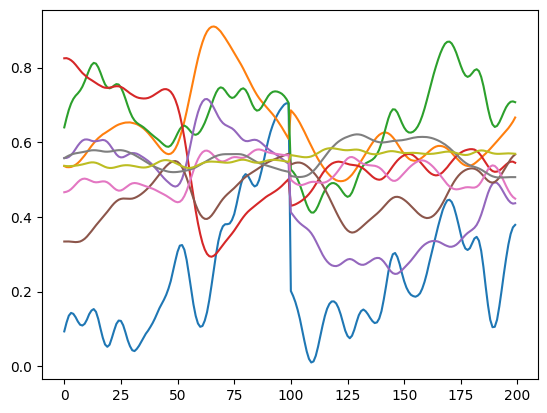

In [94]:
plt.plot(NormalizeData(Y)[:,50:250].T)

# Train Vine

In [95]:
from copulagp.train import train_vine

train_vine(
    path_data=lambda x: f'../data/vine_data_{x}.pkl', 
    path_models=lambda x: f'./notebook1_1/layer_{x}.pkl', 
    path_final=f'./notebook1_1/results/traj_{N}_res.pkl', 
    path_logs=lambda a,b: f'./logs/notebook1_1_cop/{a}/layer_{b}', 
    exp=f'Vine on {N} trajectories',
    light=True,
    start=0
    )

Starting Vine on 9 trajectories layer 0/8
Error:[Errno 17] File exists: './logs/notebook1_1_cop/Vine on 9 trajectories/layer_0'


KeyboardInterrupt: 

0-2 Clayton90°Clayton180° -0.496 took 115 min
0-1 GaussianClayton0°Clayton90°Clayton180° -0.1394 took 157 min


In [16]:
import copulagp.vine as v
import copulagp
import torch
import pickle as pkl

In [17]:
with open('./notebook1_1/results/traj_9_res.pkl', 'rb') as f:
    results = pkl.load(f)

In [18]:
results['models']

[[<copulagp.bvcopula.models.Pair_CopulaGP_data at 0x28fc076d0>,

In [20]:
len(results['models'])

8

Text(0.5, 1.08, 'Low Level Copula: Trajectories 1,4 unconditioned')

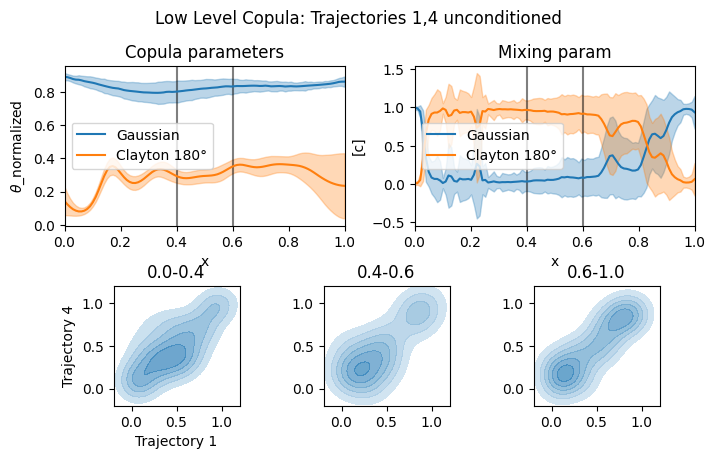

In [21]:
from copulagp.utils import Plot_Fit
try:
    Plot_Fit(
        results['models'][0][2].model_init(torch.device('cpu')),
        np.arange(0,1,0.01),
        Y.T[:100],
        'Trajectory 1',
        'Trajectory 4',
        torch.device('cpu')
        )
except TypeError:
    pass
plt.suptitle('Low Level Copula: Trajectories 1,4 unconditioned',y=1.08)

Text(0.5, 1.08, 'Low Level Copula: Trajectories 1,2 unconditioned')

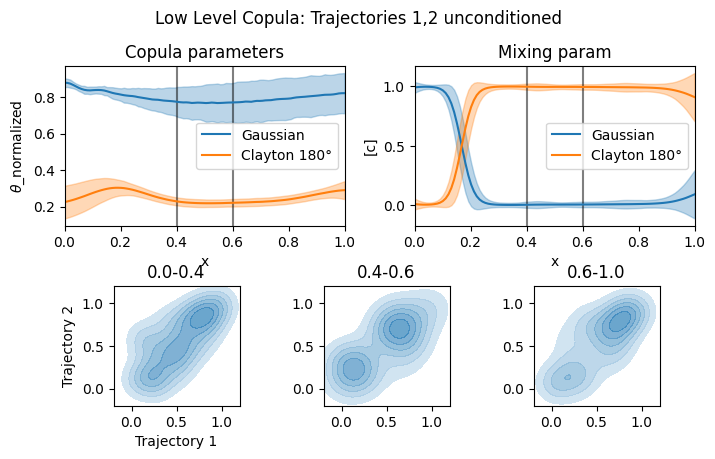

In [22]:
from copulagp.utils import Plot_Fit
try:
    Plot_Fit(
        results['models'][0][0].model_init(torch.device('cpu')),
        np.arange(0,1,0.01),
        Y.T[:100],
        'Trajectory 1',
        'Trajectory 2',
        torch.device('cpu')
        )
except TypeError:
    pass
plt.suptitle('Low Level Copula: Trajectories 1,2 unconditioned',y=1.08)

Text(0.5, 1.08, 'Mid Level Copula: Trajectories 2,4 conditioned on 1')

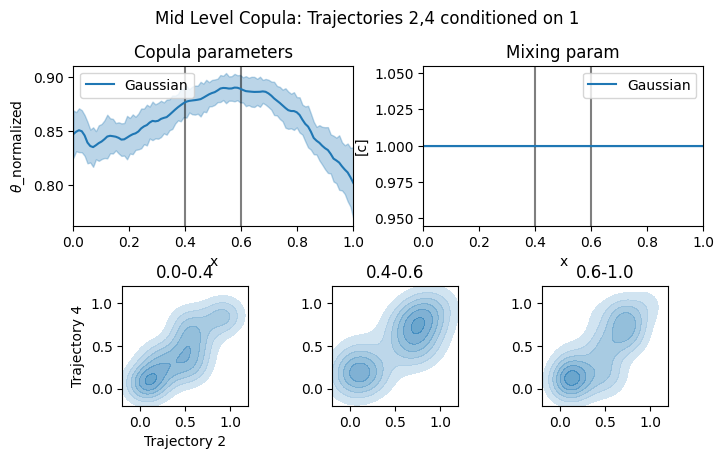

In [23]:
from copulagp.utils import Plot_Fit
try:
    Plot_Fit(
        results['models'][1][1].model_init(torch.device('cpu')),
        np.arange(0,1,0.01),
        Y.T[:100],
        'Trajectory 2',
        'Trajectory 4',
        torch.device('cpu')
        )
except TypeError:
    pass
plt.suptitle('Mid Level Copula: Trajectories 2,4 conditioned on 1',y=1.08)

Text(0.5, 1.08, 'Highest Level Copula: Trajectories 6,7 conditioned on 1,2,3,4,5')

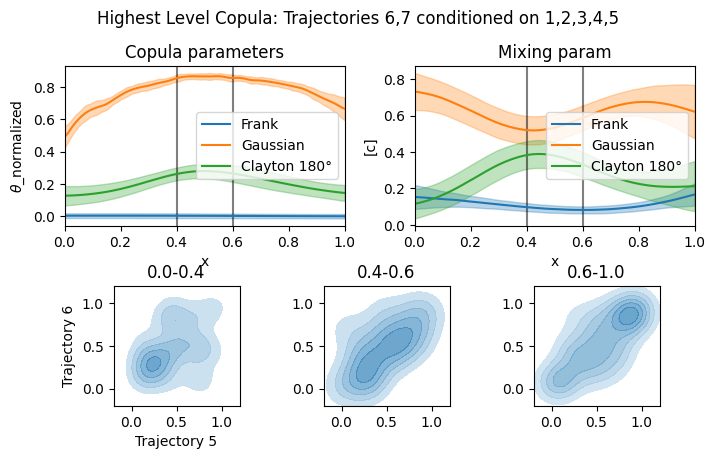

In [26]:
from copulagp.utils import Plot_Fit
try:
    Plot_Fit(
        results['models'][7][0].model_init(torch.device('cpu')),
        np.arange(0,1,0.01),
        Y.T[:100],
        'Trajectory 5',
        'Trajectory 6',
        torch.device('cpu')
        )
except TypeError:
    pass
plt.suptitle('Highest Level Copula: Trajectories 6,7 conditioned on 1,2,3,4,5',y=1.08)

In [27]:

from copulagp import bvcopula
import copy
import tqdm

model_data = copy.deepcopy(results['models'])

for i,layer in enumerate(model_data):
    for j,cop_data in enumerate(layer):
        cop = cop_data.model_init('cpu').marginalize(torch.arange(0,1,0.01))
        model_data[i][j]=cop
vine = v.CVine(model_data,torch.arange(0,1,0.01))

In [32]:
vine_sample = DenormalizeData(np.array([vine.sample().numpy().T for i in range(1)]).mean(axis=0),min=Y_min,max=Y_max)
vine_sample.shape

(9, 100)

Text(0.5, 0, 'Time (s) since Stimulus Onset')

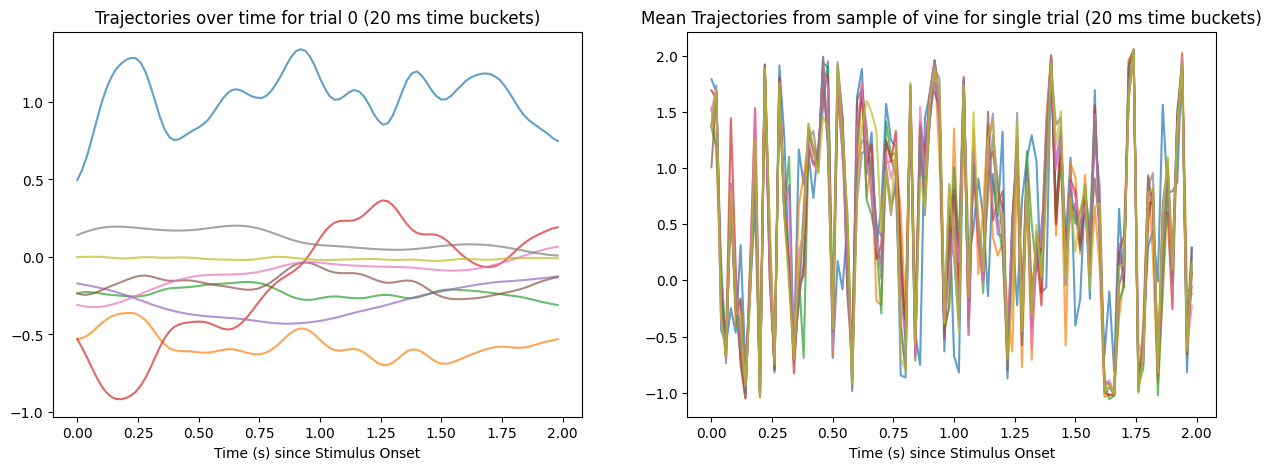

In [33]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))

for traj in traj_data[0]:
    ax1.plot(np.arange(0,2,0.02), traj, alpha=0.7)
ax1.set_title('Trajectories over time for trial 0 (20 ms time buckets)')
ax1.set_xlabel('Time (s) since Stimulus Onset')

for traj in vine_sample:
    ax2.plot(np.arange(0,2,0.02), traj, alpha=0.7)
ax2.set_title('Mean Trajectories from sample of vine for single trial (20 ms time buckets)')
ax2.set_xlabel('Time (s) since Stimulus Onset')

In [35]:
vine.entropy()

[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [ ]:
H = _